# Vector Auto Regression (VAR)
To tackle our final research question, we attempt to do a predictive modeling on water stress. Since multiple interacting time series are involved, we use multi-variate time series analysis. Vector Auto Regression (VAR) is chosen for this purpose. In addition, China is chosen as a country for analysis.

## Load libraries and functions

In [18]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# VAR
from myVAR import myVAR,adfuller_test,plot_vars,plot_comparison

# ignore warning
import warnings
warnings.filterwarnings('ignore')

## Instantiate a myVAR object with parameters
All the VAR related code is in a python script, written within a python class. We utilize functions, methods, and properties to structure the code. We first instantiate a myVAR object using data from China.

Here, water stress is linearly interpolated, since aquastat data is given within 5-year intervals. We acknowledge that this will have considerable impacts on the analysis, but no alternative data for water stress was found.

The data set has 5 columns and 17 rows.

In [19]:
# select china
country='China'

# load data for China and set Year as index
ts=pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/var_data_COMPLETE.csv',index_col='Year')
ts.shape
ts=ts.loc[ts['Country'] == country]
ts.drop(columns=['Country'],inplace=True)
# linear interpolation of Water stress
ts.interpolate(method='linear', axis=0,inplace=True)

# instantiate a myVAR object
v1=myVAR(ts)

Let us view the time series of different variables for China. The data is from 2004 to 2020 for mean annual temperature, mean annual precipitation, population density (per sq. km), GDP per capita ($USD), and water stress (%), which an indicator in UN Sustainable Development Goals (SDG) (Indicator 6.4.2 “Level of Water Stress: Freshwater Withdrawal as a Proportion of Available Freshwater Resources” - Sdg6monitoring, n.d.).

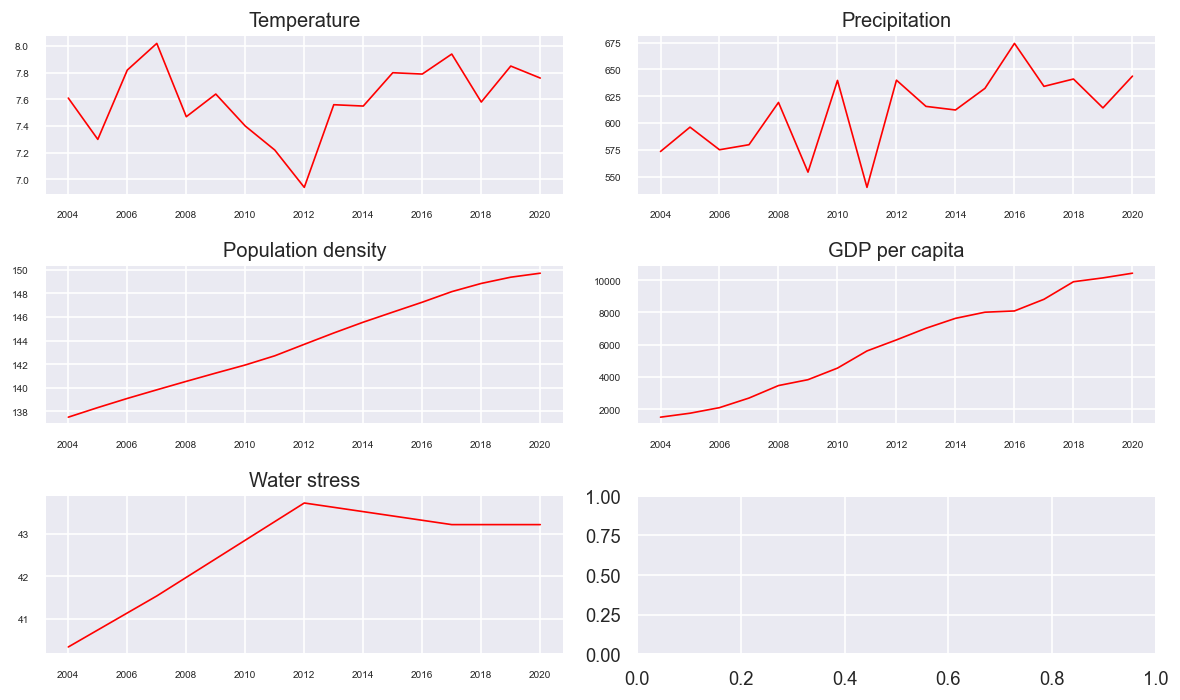

In [20]:
plot_vars(ts)

## Train/Validation split
Now to validate the model, 10% of observations (1 point) is reserved for validation. This is a small number, but owing to the small sample size of 17, this was unavoidable. 
Moreover, due to presence of autocorrelation, cross-validation is also not possible, as random shuffling of folds would distort the autocorrelation patterns.

In [21]:
nobs=1
v1.ts_split(nobs)

## Statistical tests
### ADF Test for stationarity
To do time series analysis, first the series must be stationary. From the plots above it can be seen that some clear linear trends can be observed. 

Augmented Dickey-Fuller Test (ADF Test) is used to test for stationarity (with 5% significant).
Differencing the series can remove the linear trend, however, some variables require more than 1 degree to become stationary. In this case, after 2 orders of differencing, all but water stress become stationary. This problem could not be reliably solved, as the sample size is small. Also, changing of model parameters would result in different order result. Therefore, we proceed for now.

In [22]:
diff_order=2 #parameter
v1.ts_train_diff=v1.get_diff(v1.ts_train,diff_order,verbose=True)


ADF "Temperature" 
 -----------------------------------------------
 Significance Level    = 0.05
 Test Statistic        = -0.6183
 No. Lags Chosen       = 5
 Critical value 1% = -4.332
 Critical value 5% = -3.233
 Critical value 10% = -2.749
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.8668. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary. 1

ADF "Precipitation" 
 -----------------------------------------------
 Significance Level    = 0.05
 Test Statistic        = -1.3172
 No. Lags Chosen       = 1
 Critical value 1% = -4.012
 Critical value 5% = -3.104
 Critical value 10% = -2.691
 Null Hypothesis: Data has unit root. Non-Stationary.
 => P-Value = 0.6213. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary. 2

ADF "Population density" 
 -----------------------------------------------
 Significance Level    = 0.05
 Test Statistic        = 0.0587
 No. Lags Chosen       = 6
 Critical value 1% = -4.473
 Critical v

### Granger’s Causality 
Next, to do vector autoregression, it is important to verify that variables, indeed, have connections with one another. 

To this end, our first test is Granger's Causality test (Granger, 1969). The test takes a pair of time series, and if its result is significant, it indicates that time series X is useful for predicting time series Y; i.e., X Granger causes Y. Note that Granger causality is not causality in the semantic sense, rather an indication of 'precedence' or 'temporal relation'.

The heatmap displays the matrix of causality for all possible pair combinations. Significant values (p<0.05) are dark. It is seen that all variables Granger cause water stress at 5% significance level, except temperature. However, temperature Granger causes population density, which is an important variable for water stress. Thus, we proceed with our variables.

<AxesSubplot:>

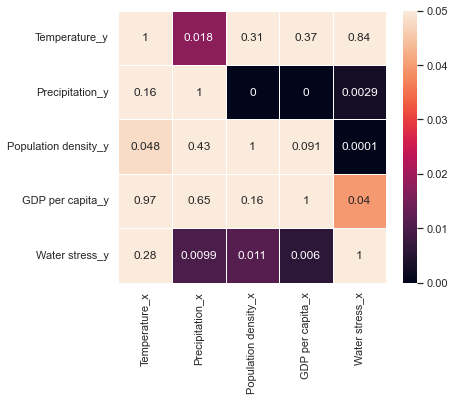

In [23]:
granger_result=v1.granger_matrix(verbose=False)
plt.figure(figsize=(6,5))
sns.heatmap(granger_result,annot=True, linewidths=.5, vmax=.05)

### Johanssen's Cointegration test

Another test for identification of connection between time series is Johanssen's Cointegration Test (Johansen, 1991). 

The results indicate that most of the variables have significant relationships, so we proceed.


In [24]:
v1.cointegration_test()

Name::Test Stat > C(95%)=>Signif  
 ----------------------------------------
Temperature ::  155.19 > 60.0627  =>   Sig.
Precipitation ::  64.48 > 40.1749  =>   Sig.
Population density ::  26.1 > 24.2761  =>   Sig.
GDP per capita ::  4.09 > 12.3212  =>   Not sig.
Water stress ::  0.89 > 4.1296  =>   Not sig.


## Model fitting
### Lag value selection
An important hyperparameter for the VAR model is the lag value $p$, which determines how many predecessor points are taken into account in the autoregression model.

 Here, for different values of lag, we inspect the fit quality using information criteria - e.g. Akaike Information Criterion (AIC). Note that due to the small size of data set in this instance, higher lag values produce undesired artifacts and software errors. Therefore, we choose 1 as our lag value.

In [25]:
v1.inspect_lag(5)

1 {'aic': 7.587184317764241, 'bic': 8.89091360421394, 'hqic': 7.319209247370907, 'fpe': 2876.82879305131}
ERROR: CANNOT FIT DURING LAG INSPECTION
3 {'aic': -278.7431725204021, 'bic': -275.84938871823215, 'hqic': -280.5672978596939, 'fpe': -1.9423901158763005e-124}
4 {'aic': -291.0576242596741, 'bic': -287.88048078323664, 'hqic': -294.54294290946706, 'fpe': -5.308120723827902e-134}
5 {'aic': -297.78777289480274, 'bic': -294.9389734443906, 'hqic': -303.93547265858854, 'fpe': -4.9456574842254397e-141}


In [26]:
p=1
v1.fit = v1.get_fit(p)
v1.fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Jun, 2022
Time:                     16:56:21
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    8.89091
Nobs:                     13.0000    HQIC:                   7.31921
Log likelihood:          -111.548    FPE:                    2876.83
AIC:                      7.58718    Det(Omega_mle):         431.383
--------------------------------------------------------------------
Results for equation Temperature
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.021471         0.133374            0.161           0.872
L1.Temperature               -0.493990         0.348961           -1.416           0.157
L1.Precipitation      

### Autocorrelation residuals
The plot below shows that all autocorrelation residuals are not exceeding the cutoff (except one mild deviation). Therefore, we conclude that no significant problems w.r.t. autocorrelation are observed.

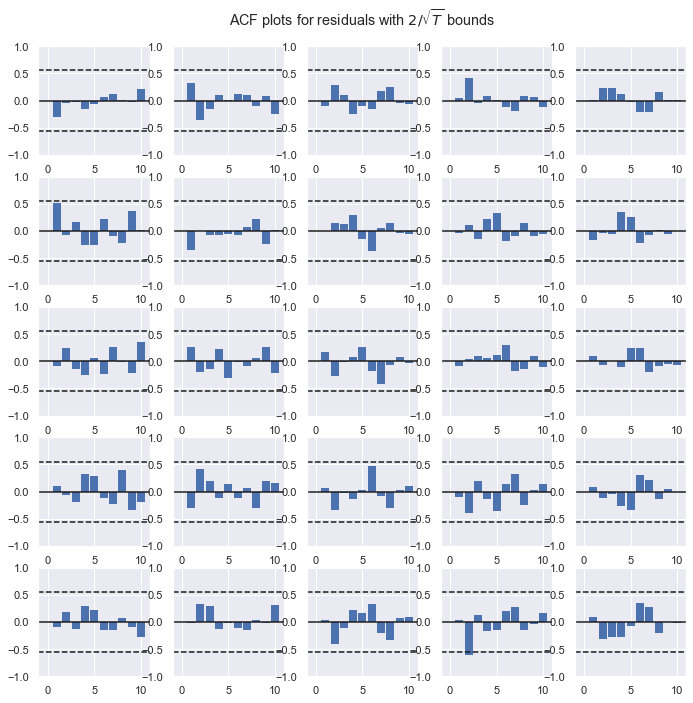

In [27]:
v1.fit.plot_acorr();

### Checking serial correlation
Durbin-Watson Test (Durbin & Watson, 1950) is performed to check for serial correlation. The aim is to see whether there are leftover patterns in the residuals. The values should ideally be equal to 2; since the values do not strongly deviate from 2, we conclude that the model is performing acceptable w.r.t. serial correlation.

2.37 Temperature
2.63 Precipitation
1.63 Population density
2.04 GDP per capita
1.46 Water stress


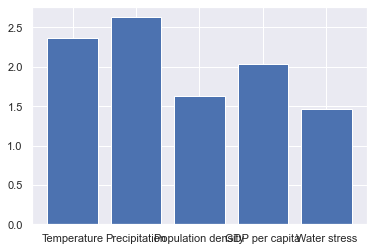

In [28]:
v1.check_serial_correlation(plot=True)

## Forecast
We first have to get the differenced forecast values. We forecast for 5 steps into the future (until 2024). As mentioned before, due to limited sample size, projections into farther points come with very high amounts of error. 

We also get forecast interval for 95% significant level.

In [29]:
forecast_steps=5
v1.ts_forecast_diff,v1.ts_forecast_diff.lower,v1.ts_forecast_diff.upper=v1.get_forecast_diff(forecast_steps,plot=False)
v1.ts_forecast_diff

,Temperature_d2,Precipitation_d2,Population density_d2,GDP per capita_d2,Water stress_d2
2020,-0.157729,87.360551,-0.039579,8.292619,0.008842
2021,0.169986,-78.166058,-0.044637,-9.953742,-0.079195
2022,-0.214875,67.786828,-0.015492,-78.147350,0.051024
2023,0.240201,-45.388873,-0.018083,3.500530,-0.091013
2024,-0.196432,35.663808,-0.019103,5.029542,-0.002500


### Invert differencing
We now have to bring the forecasts, which are 2 order differenced, into their original scales.

In [30]:
v1.ts_forecast = v1.get_inv_diff(v1.ts_forecast_diff,diff_order)
v1.ts_forecast.lower = v1.get_inv_diff(v1.ts_forecast_diff.lower,diff_order)
v1.ts_forecast.upper = v1.get_inv_diff(v1.ts_forecast_diff.upper,diff_order)
v1.ts_forecast.tail()

,Temperature,Precipitation,Population density,GDP per capita,Water stress
2020,7.962271,674.590551,149.856923,10390.626955,43.230529
2021,8.244528,656.855044,150.301636,10627.461997,43.160175
2022,8.311910,706.906365,150.730856,10786.149690,43.140846
2023,8.619493,711.568813,151.141993,10948.337912,43.030504
2024,8.730645,751.895069,151.534027,11115.555676,42.917661


Here, we add the forecasted values to training data.

In [31]:
v1.ts_results=pd.concat([v1.ts_train,v1.ts_forecast])
v1.ts_results.lower=pd.concat([v1.ts_train,v1.ts_forecast.lower])
v1.ts_results.upper=pd.concat([v1.ts_train,v1.ts_forecast.upper])
v1.ts_results.tail(10)
v1.ts.tail()

,Temperature,Precipitation,Population density,GDP per capita,Water stress
Year,,,,,
2016,7.79,674.29,147.250303,8094.363367,43.323936
2017,7.94,634.22,148.144225,8816.986905,43.221687
2018,7.58,641.09,148.838644,9905.342004,43.221687
2019,7.85,614.16,149.367573,10143.838170,43.221687
2020,7.76,643.78,149.705447,10434.775190,43.221687


## Model Validation
Having trained the model on training data, we now calculate errors on the test data. The used measures are: 

1. Mean percentage error (MPE)
2. Mean absolute percentage error (MAPE)
3. Mean error (ME)
4. Mean absolute error (MAE)
5. Root mean squared error (RMSE)

It can be seen that the errors are not high for all the variables for all the measures, which indicates a good fit on the final observation.

In [32]:
error_test=v1.get_forecast_error(v1.ts_forecast)
error_test
# error.loc[['RMSE'],['Water stress']]

,Temperature,Precipitation,Population density,GDP per capita,Water stress
ME,0.026066,0.047859,0.001012,-0.004231,0.000205
MPE,0.026066,0.047859,0.001012,0.004231,0.000205
MAE,0.202271,30.810551,0.151476,-44.148235,0.008842
MAPE,0.202271,30.810551,0.151476,44.148235,0.008842
RMSE,0.202271,30.810551,0.151476,44.148235,0.008842


Below, the forecasted values and actuals values are visualized. It can be seen that even for such a short interval, the confidence bands are very large, indicating the high uncertainty in our prediction.

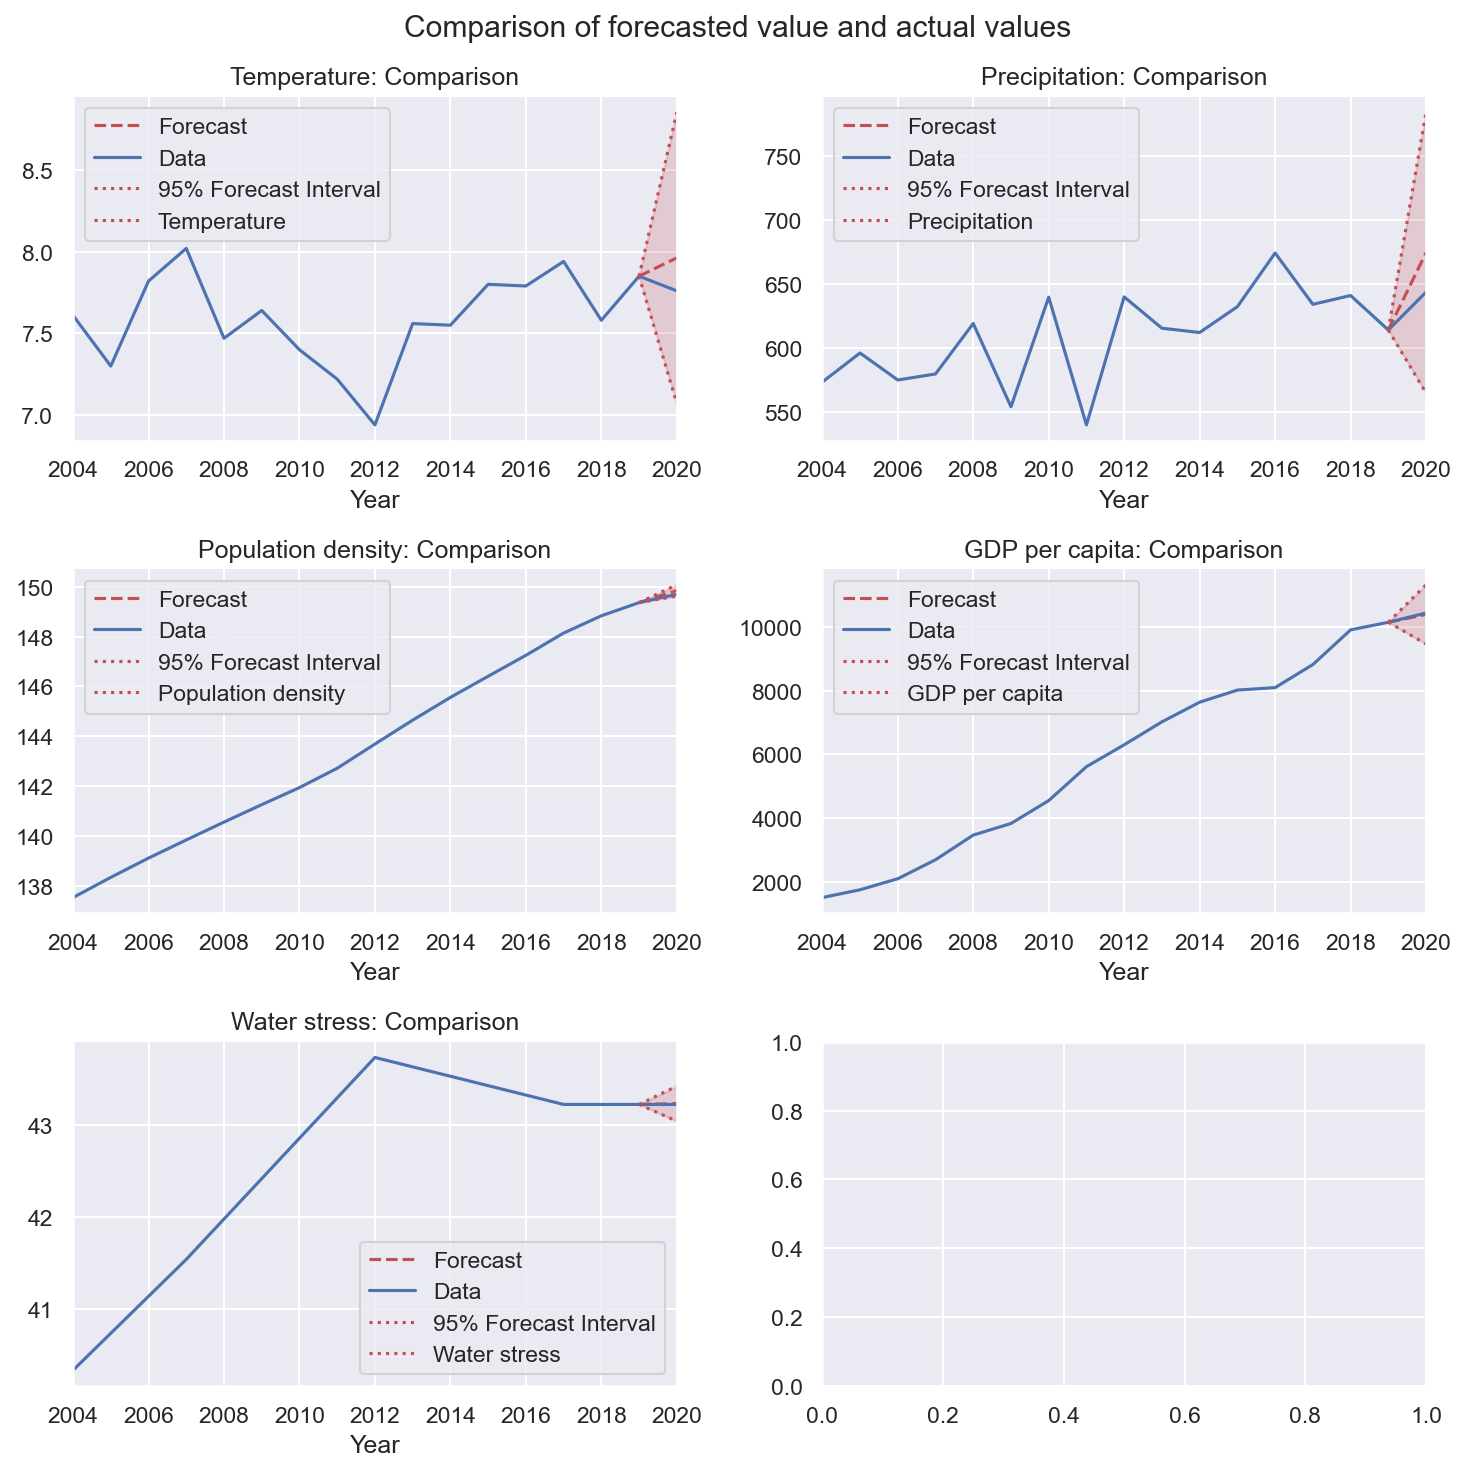

In [33]:
plot_comparison(v1,
    steps=nobs, 
    name='Comparison of forecasted value and actual values',
    interval=True,
    figsize=(10,10))

The uncertainty issue gets worse as we project further into the future.

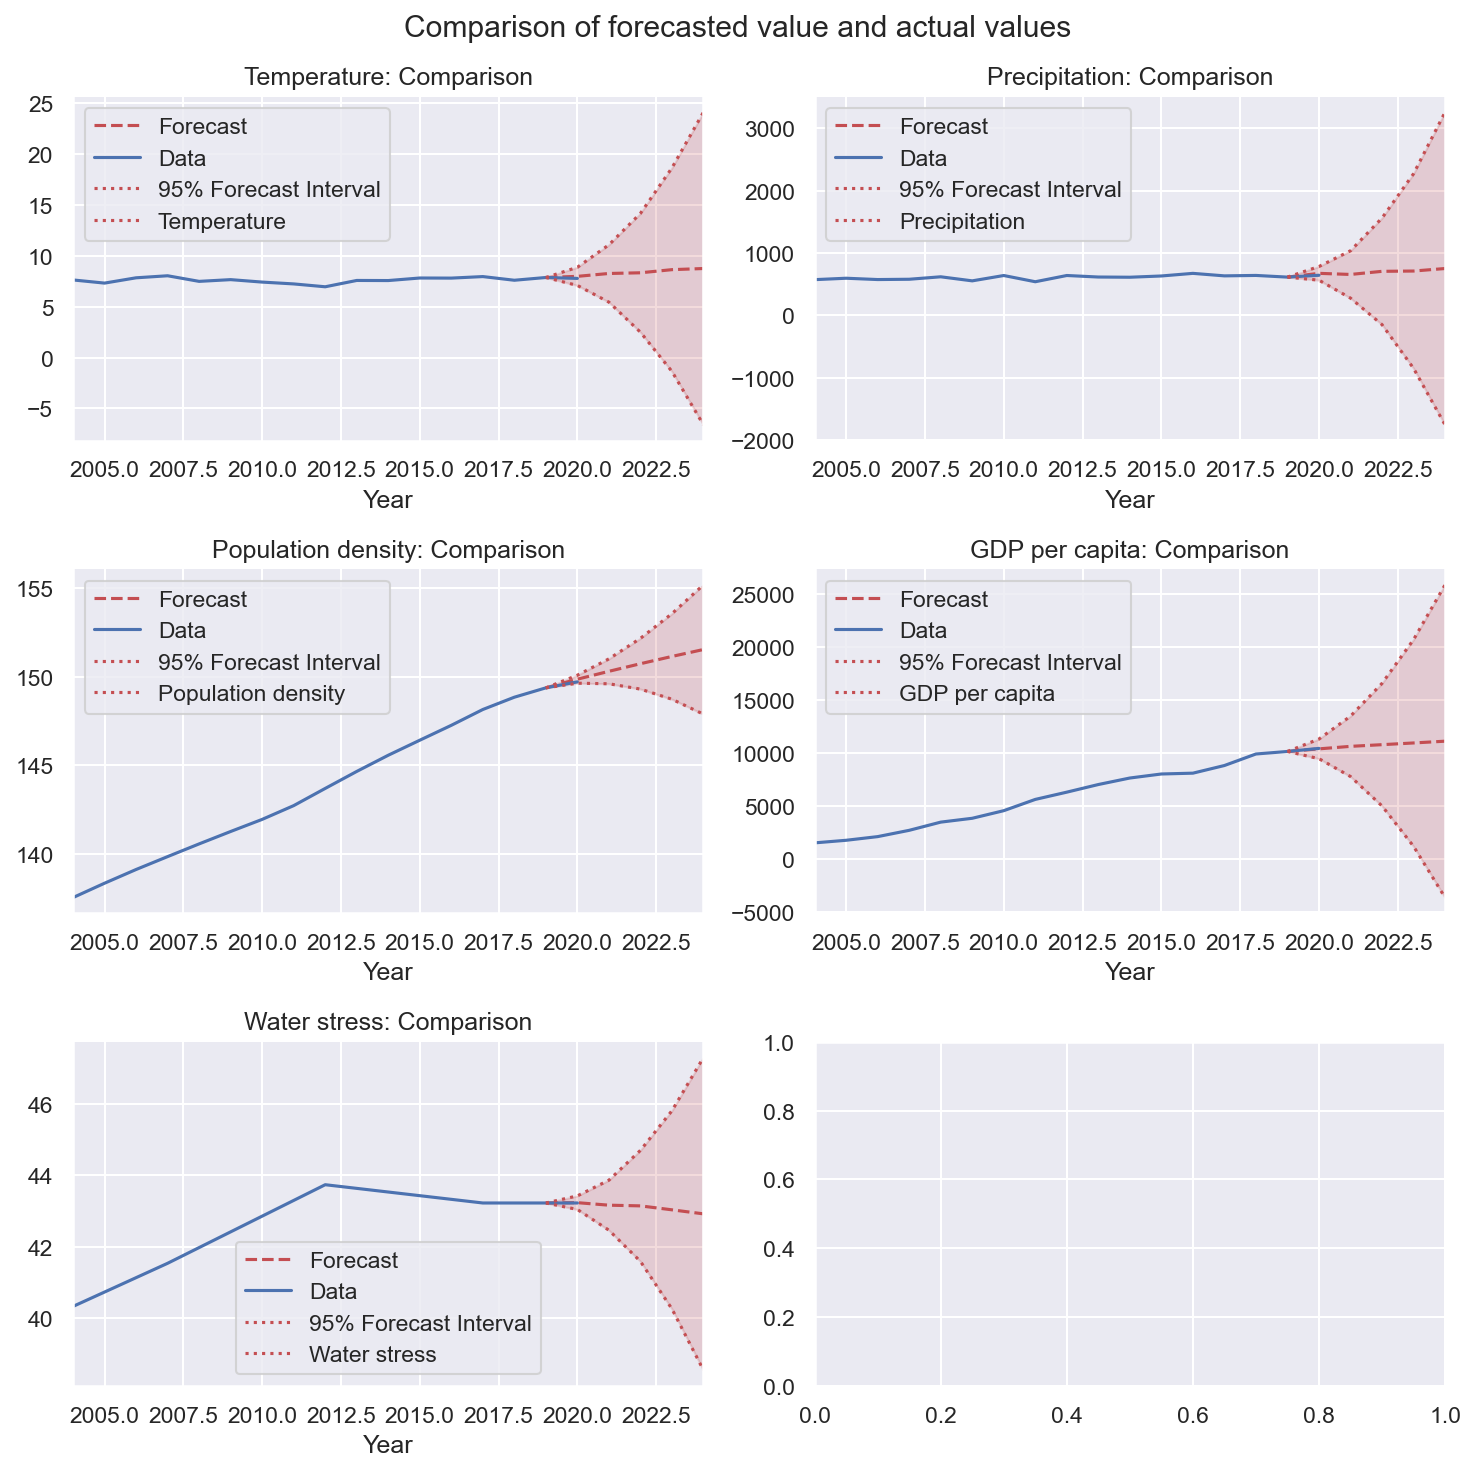

In [34]:
plot_comparison(v1,
    steps=forecast_steps, 
    name='Comparison of forecasted value and actual values',
    interval=True,
    figsize=(10,10))

## Conclusion
To answer the question: 
> How well can we predict water stress with limited available data?

We managed to predict water stress given the 4 selected variables for 17 years; however, the prediction power of our VAR model is very limited, so its results should be treated with care. One of the major reasons behind this is lack of sufficient data. 17 datapoints are not sufficient for time series analysis of this nature. Another reason are the selected variables themselves. We did select these variables mainly with 2 reasons in mind: (1) scientific literature (Shuang & Zhao, 2021), (2) our analysis of aquastat. However, the selected variables are not ideal. Firstly, the variables and observations chosen here, are not the same as the ones from aquastat. Second, the literature suggested variables for water demand and water shortage, not water stress directly. Although these concepts are related, they do differ in some aspects. Nevertheless, the procedure/pipeline presented in this notebook can work well with proper data, and this has been tested with other benchmark datasets.



## References
Durbin, J., & Watson, G. S. (1950). Testing for Serial Correlation in Least Squares Regression: I. Biometrika, 37(3/4), 409–428. https://doi.org/10.2307/2332391

Granger, C. W. J. (1969). Investigating Causal Relations by Econometric Models and Cross-spectral Methods. Econometrica, 37(3), 424–438. https://doi.org/10.2307/1912791

Indicator 6.4.2 “Level of water stress: Freshwater withdrawal as a proportion of available freshwater resources”—Sdg6monitoring. (n.d.). https://www.sdg6monitoring.org/indicator-642/

Johansen, S. (1991). Estimation and Hypothesis Testing of Cointegration Vectors in Gaussian Vector Autoregressive Models. Econometrica, 59(6), 1551–1580. https://doi.org/10.2307/2938278

Shuang, Q., & Zhao, R. T. (2021). Water Demand Prediction Using Machine Learning Methods: A Case Study of the Beijing–Tianjin–Hebei Region in China. Water, 13(3), 310. https://doi.org/10.3390/w13030310


